## LTFS

### Evaluation metrics for imbalanced multi-class clasification
1. [Metrics for multi-class classification: An overview by Grandini, Bagali, Visani](https://arxiv.org/abs/2008.05756)
1. [Performance Measures for Multi-Class Problems by Matthias Doring](https://www.datascienceblog.net/post/machine-learning/performance-measures-multi-class-problems/)
1. [What metrics should be used for evaluating a model on an imbalanced data set? TPR, FPR, ROC](https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba)
1. [Classification/evaluation metrics for highly imbalanced data](https://stats.stackexchange.com/questions/222558/classification-evaluation-metrics-for-highly-imbalanced-data)
1. [Tour of evaluation metrics for imbalanced classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)
**Measures:**
1. Accuracy
1. Weighted accuracy
1. Micro and macro averages. Compute 1vsAll confusion matrices, compute precision and recall for each matrix, having that we may compare outputs between classes.
    * Micro average: may be particularly misleading when the distribution in imbalanced. It summarizes overall performance of the model, not taking into account bad performance on some classes.
    * Macro average: more suitable for imbalanced data 
1. ROC curve for 1vsAll setting. 
1. AUC for the multi-class setting (AUC by Hand and Till):
1. FPR and TPR measure the ability to distinguish between the classes
1. Kappa 
1. G-measure
1. Jaccard index
<br><br>
**In a binary setting:**
1. Use precision and recall to focus on small positive class (small umber of positive examples, we need to focus on finding positive thus negatives are easy)
1. ROC when the distribution is equal (both classes equally important)
1. Use ROC if the majority is positive as precision and recall won't show us anything, or switch labels.

### Imbalanced datasets - oversampling and undersampling
1. [Documentation of imbalanced learn](https://imbalanced-learn.org/stable/user_guide.html#user-guide)
1. RandomOverSampler and RandomUnderSampler [here](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/)
    * Pipeline -> Oversampling, undersampling and then classifier (combine both techniques)
1. Creating artificial examples - SMOTE [here](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
    * Pipeline -> Random undersampling (trim examples in majority class), SMOTE (oversample minority class)
    * or Pipeline -> SMOTE, undersampling majority class
1. Extensions to SMOTE - ADASYN, Borderline-SMOTE
    * ADASYN - create artificial samples based on the distribution (where there is less samples, create artificial ones, where the denistiy is high - less artificial samples shall be created)

### Pipelines
**Useful articles:**
1. https://iaml.it/blog/optimizing-sklearn-pipelines
1. https://analyticsindiamag.com/hands-on-tutorial-on-machine-learning-pipelines-with-scikit-learn/
1. [More custom transfpormers](https://machinelearningmastery.com/create-custom-data-transforms-for-scikit-learn/)
1. [Transformers - column, featureunion](https://scikit-learn.org/stable/modules/compose.html)
1. [Pipelines on Titanic](https://medium.com/analytics-vidhya/scikit-learn-pipelines-with-custom-transformer-a-step-by-step-guide-9b9b886fd2cc)
1. [Great step-by-step course on ML topics](https://bradzzz.gitbooks.io/ga-seattle-dsi/content/)
1. [Super important - preprocessing on target variable](https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/)

### Multi-class classification algorithms:
1. https://scikit-learn.org/stable/modules/multiclass.html
    * OneVsRest (one vs all) - interpretability (one classifier is assigned to only one class)

In [191]:
import pandas as pd  
import numpy as np
import pandas_profiling  # Quick and easy Exploratory Data Analysis
from sklearn.pipeline import Pipeline
import seaborn as sns  # Heatmap
import matplotlib.pyplot as plt

# Data transformation
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler, RobustScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Imbalanced learning 
from imblearn.over_sampling import SMOTE  # Oversampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline  # specific pipeline for imblearn functions

# Training, testing phase
from sklearn.model_selection import RepeatedStratifiedKFold  #Cross validation keeping distribution
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics

# Classifiers
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

## Data visualisation + understanding

### 1. lfts3_train (26 columns with target value)

In [66]:
train_dataset = pd.read_csv("ltfs3_train.csv")

In [67]:
print(train_dataset.shape)
train_dataset.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,...,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,...,1568,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,...,1062,34802,70.00,M,23.0,666.67,SEHORE,MADHYA PRADESH,466001.0,No Top-up Service
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,...,1060,127335,69.77,M,39.0,45257.00,BHOPAL,MADHYA PRADESH,462030.0,12-18 Months
3,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,...,1060,25094,80.92,M,24.0,20833.33,ASHOK NAGAR,MADHYA PRADESH,473335.0,> 48 Months
4,8,Monthly,Arrear,Closed,Billed,152,BILASPUR,44,619265,440000.0,...,1046,21853,71.05,M,56.0,27313.67,BILASPUR,CHATTISGARH,495442.0,36-48 Months


In [68]:
train_dataset.Tenure.value_counts()

36     36977
48     25672
24     14327
60     12209
42      4864
       ...  
171        1
110        1
112        1
99         1
141        1
Name: Tenure, Length: 141, dtype: int64

In [74]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128655 entries, 0 to 128654
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               128655 non-null  int64  
 1   Frequency        128655 non-null  object 
 2   InstlmentMode    128655 non-null  object 
 3   LoanStatus       128655 non-null  object 
 4   PaymentMode      128655 non-null  object 
 5   BranchID         128655 non-null  int64  
 6   Area             117002 non-null  object 
 7   Tenure           128655 non-null  int64  
 8   AssetCost        128655 non-null  int64  
 9   AmountFinance    128655 non-null  float64
 10  DisbursalAmount  128655 non-null  float64
 11  EMI              128655 non-null  float64
 12  DisbursalDate    128655 non-null  object 
 13  MaturityDAte     128654 non-null  object 
 14  AuthDate         128655 non-null  object 
 15  AssetID          128655 non-null  int64  
 16  ManufacturerID   128655 non-null  int6

In [70]:
train_dataset.describe()

,ID,BranchID,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,AssetID,ManufacturerID,SupplierID,LTV,AGE,MonthlyIncome,ZiPCODE
count,128655.000000,128655.000000,128655.000000,1.286550e+05,1.286550e+05,1.286550e+05,128655.000000,1.286550e+05,128655.000000,128655.000000,128655.000000,128596.000000,1.284210e+05,128283.000000
mean,70965.326556,166.289674,42.464778,5.550247e+05,3.483096e+05,3.479306e+05,55072.758506,1.639773e+07,1171.327271,56551.226210,59.126226,40.664803,5.032360e+04,427931.099725
std,41762.779285,115.844048,23.533972,1.083036e+05,1.055453e+05,1.053198e+05,28910.111740,9.539540e+06,257.790208,36399.355276,15.539038,11.712847,1.724607e+06,175704.364031
min,1.000000,1.000000,5.000000,2.000000e+05,5.000000e+04,2.894000e+03,0.000000,4.222710e+05,1019.000000,5879.000000,-1.380000,18.000000,0.000000e+00,110000.000000
25%,34408.500000,50.000000,36.000000,5.000000e+05,2.900000e+05,2.900000e+05,32500.000000,9.438948e+06,1046.000000,24093.000000,49.140000,31.000000,2.500000e+04,304804.000000
50%,70988.000000,152.000000,36.000000,5.507350e+05,3.500000e+05,3.500000e+05,59700.000000,1.513393e+07,1062.000000,39146.000000,60.780000,40.000000,3.583333e+04,458553.000000
75%,106549.500000,274.000000,48.000000,6.110000e+05,4.100000e+05,4.100000e+05,73800.000000,2.533396e+07,1186.000000,87034.000000,70.590000,49.000000,5.000000e+04,521131.000000
max,143395.000000,424.000000,501.000000,2.250000e+06,1.308351e+06,1.308351e+06,460000.000000,3.706667e+07,3473.000000,145518.000000,100.000000,90.000000,6.174775e+08,855456.000000


In [201]:
train_dataset['Top-up Month'].value_counts()

6    106677
0      8366
5      3656
3      3492
4      3062
2      2368
1      1034
Name: Top-up Month, dtype: int64

In [202]:
train_dataset['Top-up Month'].value_counts().apply(lambda x: x/train_dataset.shape[0])

6    0.829171
0    0.065027
5    0.028417
3    0.027142
4    0.023800
2    0.018406
1    0.008037
Name: Top-up Month, dtype: float64

### 2. ltfs3_train_bureau
This dataset contains payments of bank clients. It is not used for further training, is does not contain target variable. Using it would imply changing the imput completly.

In [ ]:
train_bureau_dataset = pd.read_csv("ltfs3_train_bureau.csv")
train_bureau_dataset.info()

In [76]:
train_bureau_dataset.shape

(560844, 25)

For every loan in train dataframe there are multiple rows in train_bureau dataset.

In [72]:
len(pd.unique(train_bureau_dataset.ID))

128655

In [73]:
len(pd.unique(train_dataset.ID))

128655

In [80]:
train_bureau_dataset.head(15)

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,...,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,1,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,...,NaN,"37,873",0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN
1,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,...,F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0
2,1,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,...,NaN,0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,2...",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN
3,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,...,NaN,0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
4,1,True,PRIMARY,Tractor Loan,NBF,2016-02-29,Individual,Closed,2012-02-10,2016-02-01 00:00:00,...,NaN,0,0.0,NaN,"20160229,20160131,20151231,20151130,20151031,2...",0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
5,1,False,PRIMARY,Credit Card,NAB,2018-04-30,Individual,Closed,2018-01-11,2018-03-13 00:00:00,...,NaN,NaN,0.0,Standard,"20180331,20180228,20180131,",000000000,"24650,17300,0,",",,,",",,,,",NaN
6,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-11-15,NaN,...,F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",000000000000000000000000000000000000000000,"443769,448365,453134,457687,462320,466802,4712...",",,,,,,,,,,,,,,",",,,,,,,,,,,,,,",84.0
7,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-01-30,2017-09-21 00:00:00,...,NaN,0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0000000000000870540270270000320000000000...,"0,,0,0,0,0,0,0,0,13060,13060,25982,38767,51417...","0,,0,0,0,0,3064,3064,3064,2972,0,2802,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
8,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-07-31,Individual,Closed,2013-06-11,2017-07-01 00:00:00,...,NaN,0,0.0,NaN,"20170731,20170601,20170531,20170430,20170331,2...",000DDD0220210220190220220000270000000000000000...,"0,,0,10487,20862,31126,41281,51328,51328,71101...","0,,1722,1722,1722,1722,1722,1722,0,1625,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
9,2,False,PRIMARY,Overdraft,PRB,2017-03-31,Individual,Closed,2016-01-15,2017-03-27 00:00:00,...,NaN,0,0.0,NaN,"20170331,20170201,20170101,20161231,20161101,2...",000DDDDDD000DDDDDD000DDDDDD000DDDDDD000,"0,,,1699997,,,154997,,,-3,,,149997,","0,,,0,,,0,,,0,,,0",",,,,,,,,,,,,,,",NaN


In [77]:
#prof1 = pandas_profiling.ProfileReport(train_dataset.sample(frac=0.1), minimal=True)
#prof2 = pandas_profiling.ProfileReport(train_bureau_dataset.sample(frac=0.1), minimal=True)

In [78]:
#prof1.to_file("Train_EDA_sample.html")

In [79]:
#prof2.to_file("Train_EDA_bureau_sample.html")

### 3. Ltfs3_demographis
This dataset contains descriptions of every column in every .csv file supplied to Kaggle

In [81]:
data_description = pd.read_csv("ltfs3_demographics_dictionary.csv")

In [82]:
data_description.loc[1,"Description.1"]

'This field implies whether Tradeline belong to LTFS or not. In the event of self match value will be "True " else false.'

In [83]:
data_description

,Data,Description,Bureau Data,Description.1,CONTRIBUTOR ID,Bank Name,Account Type,Description.2
0,ID,Agreement ID (Dummy Value),ID,Agreement NO (Dummy),NBF,NBFC,A01,Auto Loan (Personal)
1,Frequency,"Frequency of the loan payment, It can be month...",SELF-INDICATOR,This field implies whether Tradeline belong to...,COP,CO-OPERATIVE BANK,A02,Auto Overdraft
2,InstlmentMode,It can be either advance or an arrear while op...,MATCH-TYPE,Type of match for Primary / Secondary or In ot...,MFI,NGO-MFI,A03,Two-Wheeler Loan
3,LoanStatus,Active Or closed Account at this point of time,ACCT-TYPE,This field implies an account type assigned by...,HFC,HOUSING FINANCE COMPANY,A04,Commercial Vehicle Loan
4,PaymentMode,Payement Mode at the start of loan. It can be ...,CONTRIBUTOR-TYPE,"Whether it’s a government bank, private bank, ...",RRB,REGIONAL RURAL BANK,A05,Commercial Equipment Loan
5,BranchID,This field implies the client's loan disbursin...,DATE-REPORTED,This field implies the date up to which inform...,FRB,FOREIGN BANK,A06,Housing Loan
6,Area,Area at which the branch is present( Superset ...,OWNERSHIP-IND,This field implies the repayment responsibility,NAB,NATIONALIZED BANK,A07,Property Loan
7,Tenure,Tenure of the loan,ACCOUNT-STATUS,This field displays the status of loan account.,PRB,PRIVATE BANK,A08,Loan Against Shares / Securities
8,AssetCost,Cost of asset involved of the given loan,DISBURSED-DT,This field implies the date of credit disburse...,INS,INSURANCE COMAPANY,A09,Gold Loan
9,AmountFinance,Most of the time its equivalent to disbursal a...,CLOSE-DT,This field implies the date of account closure.,SBI,SBI AND ASSOCIATES,A10,Education Loan


### 4. ltfs3_test - testing dataset supplied to test for Kaggle 

In [ ]:
test_dataset = pd.read_csv("ltfs3_test.csv")
test_dataset.head()

In [ ]:
test_dataset.info()

### 5. sumbission - nobody knows what is in here

In [ ]:
submission = pd.read_csv("submission.csv")
submission.head()

In [196]:
submission.describe()

,id,target
count,200000.000000,200000.000000
mean,249970.884580,7.456507
std,144169.245904,0.287940
min,0.000000,6.131957
25%,125316.750000,7.266200
50%,249997.000000,7.452647
75%,374649.750000,7.642499
max,499995.000000,9.834132


## Data preprocessing 

In [86]:
object_columns = train_dataset.select_dtypes(include=['object']).columns
float_columns = train_dataset.select_dtypes(include=['float64']).columns
integer_columns = train_dataset.select_dtypes(include=['int64']).columns

In [87]:
categorical_columns = list(set(object_columns) - 
                           set(['Area', 'DisbursalDate', 'MaturityDAte', 'AuthDate', 'City', 'State']))

In [109]:
categorical_columns

['Frequency',
 'InstlmentMode',
 'LoanStatus',
 'PaymentMode',
 'Top-up Month',
 'SEX']

In [88]:
for column in categorical_columns:
    print(train_dataset[column].value_counts())

Half Yearly    76248
Monthly        31150
Quatrly        20795
BI-Monthly       462
Name: Frequency, dtype: int64
Arrear     122349
Advance      6306
Name: InstlmentMode, dtype: int64
Closed    94457
Active    34198
Name: LoanStatus, dtype: int64
Direct Debit    31766
ECS             31390
PDC             26617
Billed          26486
PDC_E            9937
Auto Debit        843
SI Reject         744
Cheque            442
ECS Reject        417
Escrow              7
PDC Reject          6
Name: PaymentMode, dtype: int64
No Top-up Service    106677
 > 48 Months           8366
36-48 Months           3656
24-30 Months           3492
30-36 Months           3062
18-24 Months           2368
12-18 Months           1034
Name: Top-up Month, dtype: int64
M    122144
F      6452
Name: SEX, dtype: int64


In [102]:
train_dataset.loc[:,categorical_columns] = train_dataset.loc[:, categorical_columns].astype('category')

In [105]:
train_dataset.SEX.value_counts()

M    122144
F      6452
Name: SEX, dtype: int64

In [107]:
train_dataset.loc[:,categorical_columns].isna().sum()

Frequency        0
InstlmentMode    0
LoanStatus       0
PaymentMode      0
Top-up Month     0
SEX              0
dtype: int64

In [106]:
categorical_imputer = SimpleImputer(strategy='most_frequent').fit(train_dataset.loc[:, categorical_columns])
train_dataset.loc[:, categorical_columns] = categorical_imputer.transform(train_dataset.loc[:, categorical_columns])

In [108]:
train_dataset.Frequency = train_dataset.Frequency.astype('category')

In [101]:
class ToIntTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self = self
    def fit(self, X):
        return self
    
    def transform(self, X):
        X = X.astype('int64')
        return X

In [110]:
high_cardinality_columns= ['ID', 'BranchID', 'AssetID', 'ManufacturerID', 'SupplierID', 'ZiPCODE', 'Tenure']
integer_columns = ['AmountFinance', 'DisbursalAmount', 'EMI', 'LTV', 'AGE', 'MonthlyIncome', 'AssetCost']

In [111]:
pipeline_categorical = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                 ('encoder', OrdinalEncoder()),
                                ('transformer_to_int', ToIntTransformer())])

pipeline_high_cardinality = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                      ('transformer_to_int', ToIntTransformer())])

pipeline_integer = Pipeline([('imputer', SimpleImputer(strategy = 'mean')),
                            ('transformer_to_int', ToIntTransformer()),
                            ('scaler', MinMaxScaler())])



train_dataset.loc[:, categorical_columns] = pipeline_categorical.fit_transform(train_dataset.loc[:,categorical_columns])
train_dataset.loc[:, integer_columns] = pipeline_integer.fit_transform(train_dataset.loc[:,integer_columns])
train_dataset.loc[:, high_cardinality_columns] = pipeline_high_cardinality.fit_transform(train_dataset.loc[:,high_cardinality_columns])

In [112]:
train_dataset = train_dataset.loc[:, list(high_cardinality_columns+integer_columns+categorical_columns)]

## Models and pipelines

### Data with high-cardinality features

In [113]:
train_dataset.head()

,ID,BranchID,AssetID,ManufacturerID,SupplierID,ZiPCODE,Tenure,AmountFinance,DisbursalAmount,EMI,LTV,AGE,MonthlyIncome,AssetCost,Frequency,InstlmentMode,LoanStatus,PaymentMode,Top-up Month,SEX
0,1,1,4022465,1568,21946,464993,48,0.178805,0.208437,0.052174,0.613861,0.430556,0.000058,0.121951,2,1,1,9,0,1
1,2,333,4681175,1062,34802,466001,47,0.238407,0.265888,0.022826,0.702970,0.069444,0.000001,0.139024,2,0,1,7,6,1
2,3,1,25328146,1060,127335,462030,68,0.373289,0.395903,0.083261,0.693069,0.291667,0.000073,0.239024,3,1,0,3,1,1
3,7,125,13021591,1060,25094,473335,48,0.278142,0.304189,0.025217,0.801980,0.083333,0.000034,0.136585,2,0,1,1,0,1
4,8,152,3291320,1046,21853,495442,44,0.309929,0.334830,0.032609,0.712871,0.527778,0.000044,0.204520,2,1,1,1,5,1


In [ ]:
classifiers = [LogisticRegression(), DecisionTreeClassifier(), GaussianNB(), BernoulliNB()]

In [114]:
X_train_columns = list(set(train_dataset.columns) - set(['ID', 'Top-up Month']))
X_train, X_test,y_train, y_test = train_test_split(train_dataset.loc[:, X_train_columns], train_dataset['Top-up Month'])

In [115]:
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X_train, y_train)
tree_classifier.score(X_test, y_test)

0.7015918418107201

In [117]:
lg_classifier = LogisticRegression()
lg_classifier.fit(X_train, y_train)
lg_classifier.score(X_test, y_test)

lg_predictions = lg_classifier.predict(X_test)
lg_confusion = metrics.confusion_matrix(y_test, lg_predictions)

/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [118]:
lg_confusion

array([[    0,     0,     0,     0,     0,     0,  2118],
       [    0,     0,     0,     0,     0,     0,   265],
       [    0,     0,     0,     0,     0,     0,   597],
       [    0,     0,     0,     0,     0,     0,   888],
       [    0,     0,     0,     0,     0,     0,   786],
       [    0,     0,     0,     0,     0,     0,   948],
       [    0,     0,     0,     0,     0,     0, 26562]])

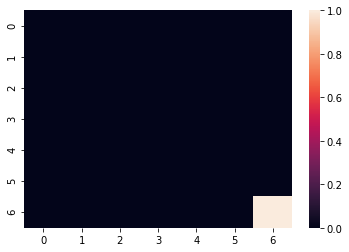

In [119]:
a = metrics.confusion_matrix(y_test, y_test)
b = np.divide(lg_confusion, a, where=a!=0)
sns.heatmap(np.round(b, 3))
plt.show()

In [120]:
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train, y_train)
dummy_classifier.score(X_test, y_test)

0.8258301206317622

In [123]:
gnb_classifier = SVC()
gnb_classifier.fit(X_train, y_train)
gnb_classifier.score(X_test, y_test)

0.8258301206317622

In [124]:
train_dataset

,ID,BranchID,AssetID,ManufacturerID,SupplierID,ZiPCODE,Tenure,AmountFinance,DisbursalAmount,EMI,LTV,AGE,MonthlyIncome,AssetCost,Frequency,InstlmentMode,LoanStatus,PaymentMode,Top-up Month,SEX
0,1,1,4022465,1568,21946,464993,48,0.178805,0.208437,0.052174,0.613861,0.430556,0.000058,0.121951,2,1,1,9,0,1
1,2,333,4681175,1062,34802,466001,47,0.238407,0.265888,0.022826,0.702970,0.069444,0.000001,0.139024,2,0,1,7,6,1
2,3,1,25328146,1060,127335,462030,68,0.373289,0.395903,0.083261,0.693069,0.291667,0.000073,0.239024,3,1,0,3,1,1
3,7,125,13021591,1060,25094,473335,48,0.278142,0.304189,0.025217,0.801980,0.083333,0.000034,0.136585,2,0,1,1,0,1
4,8,152,3291320,1046,21853,495442,44,0.309929,0.334830,0.032609,0.712871,0.527778,0.000044,0.204520,2,1,1,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128650,143390,424,31286914,1568,48879,131403,24,0.171336,0.201238,0.166957,0.405941,0.097222,0.000106,0.131707,1,1,1,3,3,1
128651,143391,424,31295422,1568,48879,131403,24,0.179306,0.208920,0.174130,0.594059,0.097222,0.000135,0.126829,1,1,1,3,6,1
128652,143393,424,32145629,1568,44118,131024,23,0.199255,0.228149,0.033211,0.524752,0.250000,0.000402,0.168293,2,1,0,3,6,1
128653,143394,424,32509866,1568,48879,131103,35,0.159703,0.190024,0.161611,0.504950,0.263889,0.000137,0.073171,1,1,0,3,6,1


### Classification when excluding high-cardinality features

In [125]:
X_train_columns2 = list(set(train_dataset.columns) - set(['ID', 'Top-up Month', 'AssetID', 'BranchID', 'ZiPCODE','ManufacturerID', 'SupplierID']))
X_train2, X_test2,y_train2, y_test2 = train_test_split(train_dataset.loc[:, X_train_columns2], train_dataset['Top-up Month'])

In [126]:
gnb_classifier2 = SVC()
gnb_classifier2.fit(X_train2, y_train2)
gnb_classifier2.score(X_test2, y_test2)

In [143]:
gnb_predictions = gnb_classifier2.predict(X_test2)
gnb_confusion = metrics.confusion_matrix(gnb_predictions, y_test2)

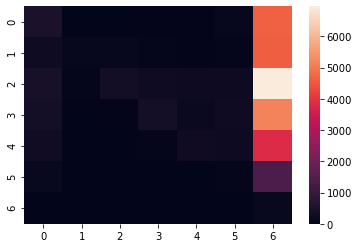

In [151]:
sns.heatmap(gnb_confusion)
plt.show()

#### Random under sampling 

In [141]:
under_sampler = RandomUnderSampler(sampling_strategy={0:830, 1:803, 2:830, 3:830, 4:830, 5:830, 6:830})
X_train2_res, y_train2_res = under_sampler.fit_resample(X_train2, y_train2)

In [142]:
gnb_classifier2.fit(X_train2_res, y_train2_res)
gnb_classifier2.score(X_test2, y_test2)

0.05534137545081458

In [145]:
pipeline3 = Pipeline([('classifiers', LogisticRegression())])
param_grid3 = [{"classifiers":classifiers}]

grid_under_sampling = GridSearchCV(pipeline3, param_grid=param_grid3)
grid_under_sampling.fit(X_train2_res, y_train2_res)    

/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

GridSearchCV(estimator=Pipeline(steps=[('classifiers', LogisticRegression())]),
             param_grid=[{'classifiers': [LogisticRegression(),
                                          DecisionTreeClassifier(),
                                          GaussianNB(), BernoulliNB()]}])

In [146]:
grid_search_proba = pd.DataFrame(grid_under_sampling.predict_proba(X_test2))
grid_search_proba['true_label'] = y_test2.sort_index(axis=0).reset_index().drop(columns=['index'])
grid_search_proba

,0,1,2,3,4,5,6,true_label
0,0.213872,0.208994,0.108725,0.064801,0.067819,0.140599,0.195190,0
1,0.135313,0.267987,0.169795,0.071049,0.059968,0.081843,0.214046,0
2,0.155095,0.272844,0.166651,0.061902,0.052661,0.078710,0.212138,5
3,0.058750,0.049565,0.123901,0.234912,0.256025,0.202629,0.074219,6
4,0.298783,0.096625,0.067132,0.065874,0.082826,0.200625,0.188136,6
...,...,...,...,...,...,...,...,...
32159,0.056787,0.008912,0.031927,0.216627,0.364691,0.230962,0.090095,6
32160,0.169947,0.239340,0.136637,0.088402,0.081968,0.176601,0.107105,1
32161,0.045998,0.142774,0.256414,0.218274,0.160802,0.081725,0.094012,6
32162,0.043004,0.069211,0.153128,0.246464,0.247055,0.169973,0.071166,6


#### Random oversampling 

In [147]:
over_sampler = RandomOverSampler(sampling_strategy='not majority')
X_train_over, y_test_over = over_sampler.fit_resample(X_train2, y_train2)

In [148]:
y_test_over.value_counts()

6    79919
5    79919
4    79919
3    79919
2    79919
1    79919
0    79919
Name: Top-up Month, dtype: int64

In [149]:
grid_under_sampling.fit(X_train_over, y_test_over)

/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

GridSearchCV(estimator=Pipeline(steps=[('classifiers', LogisticRegression())]),
             param_grid=[{'classifiers': [LogisticRegression(),
                                          DecisionTreeClassifier(),
                                          GaussianNB(), BernoulliNB()]}])

In [158]:
over_prediction = pd.DataFrame()
over_prediction['predicted_label'] = pd.DataFrame(grid_under_sampling.predict(X_test2)).iloc[:,0]
over_prediction['true_label'] = y_test2.sort_index(axis=0).reset_index().drop(columns=['index'])

In [159]:
over_prediction['is_ok'] = np.where(over_prediction['true_label'] == over_prediction['predicted_label'],1,0)

In [164]:
over_prediction # test set predictions - predicted vs true label

,predicted_label,true_label,is_ok
0,6,0,0
1,6,0,0
2,6,5,0
3,6,6,1
4,6,6,1
...,...,...,...
32159,6,6,1
32160,6,1,0
32161,6,6,1
32162,6,6,1


**Accuracy on hold-out test set for Logistic Regression model trained with random oversampling:**
<br> Test set was not oversampled.

In [160]:
over_prediction.is_ok.sum()/over_prediction.shape[0]

0.6880052232309414

In [161]:
over_prediction.predicted_label.value_counts()

6    26226
0     2243
3      942
5      939
4      854
2      671
1      289
Name: predicted_label, dtype: int64

In [162]:
over_prediction.true_label.value_counts()

6    26758
0     2080
5      964
3      800
4      779
2      552
1      231
Name: true_label, dtype: int64

This is the best from any models trained on resampled data. Even though it performs badly on test set (dummy classifier outputs 0.83 accuracy)

**Oversampled datasets exported into csvs for AutoML:**

In [ ]:
X_train_over.to_csv('/Users/jedrzejkopiszka/UniversityProjects/machine_learning/MLprojectEDA/X_train_over.csv')
y_test_over.to_csv('/Users/jedrzejkopiszka/UniversityProjects/machine_learning/MLprojectEDA/y_test_over.csv')
X_test2.to_csv('/Users/jedrzejkopiszka/UniversityProjects/machine_learning/MLprojectEDA/X_test2.csv')
y_test2.to_csv('/Users/jedrzejkopiszka/UniversityProjects/machine_learning/MLprojectEDA/y_test2.csv')

In [166]:
# Combine X_train and y_train (both oversampled) into one dataset
train_over = X_train_over
train_over['top_up_month'] = y_test_over

#### SMOTE

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [181]:
pipeline_imblearn = Pipeline([('SMOTE', SMOTE(sampling_strategy={0:70000, 1:70000, 2:70000, 3:70000, 4:70000, 5:70000, 6:79919})),
                             ('under', RandomUnderSampler(sampling_strategy='not minority')),
                             ('classifiers', LogisticRegression())])

param_grid_imblearn = {'classifiers':classifiers}

grid_SMOTE = GridSearchCV(pipeline_imblearn, param_grid=param_grid_imblearn)
grid_SMOTE.fit(X_train2, y_train2)

/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class 0 will be larger than the number of samples in the majority class (class #6 -> 63935)
  warnings.warn(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class 1 will be larger than the number of samples in the majority class (class #6 -> 63935)
  warnings.warn(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class 2 will be larger than the number of samples in the majority class (class #6 -> 63935)
  warnings.warn(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class

/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class 0 will be larger than the number of samples in the majority class (class #6 -> 63936)
  warnings.warn(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class 1 will be large

/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class 0 will be larger than the number of samples in the majority class (class #6 -> 63935)
  warnings.warn(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class 1 will be larger than the number of samples in the majority class (class #6 -> 63935)
  warnings.warn(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class 2 will be larger than the number of samples in the majority class (class #6 -> 63935)
  warnings.warn(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class

/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class 0 will be larger than the number of samples in the majority class (class #6 -> 63935)
  warnings.warn(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class 1 will be larger than the number of samples in the majority class (class #6 -> 63935)
  warnings.warn(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class 2 will be larger than the number of samples in the majority class (class #6 -> 63935)
  warnings.warn(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class

/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class 0 will be larger than the number of samples in the majority class (class #6 -> 63935)
  warnings.warn(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class 1 will be larger than the number of samples in the majority class (class #6 -> 63935)
  warnings.warn(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class 2 will be larger than the number of samples in the majority class (class #6 -> 63935)
  warnings.warn(
/Users/jedrzejkopiszka/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (70000) in class

GridSearchCV(estimator=Pipeline(steps=[('SMOTE',
                                        SMOTE(sampling_strategy={0: 70000,
                                                                 1: 70000,
                                                                 2: 70000,
                                                                 3: 70000,
                                                                 4: 70000,
                                                                 5: 70000,
                                                                 6: 79919})),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy='not '
                                                                             'minority')),
                                       ('classifiers', LogisticRegression())]),
             param_grid={'classifiers': [LogisticRegression(),
                                         DecisionTreeCla

In [182]:
grid_SMOTE_predictions = pd.DataFrame(grid_SMOTE.predict(X_test2))
grid_SMOTE_predictions['true_labels'] = y_test2.sort_index(axis=0).reset_index().drop(columns=['index'])
grid_SMOTE_predictions['is_ok'] = np.where(grid_SMOTE_predictions.iloc[:,0] == grid_SMOTE_predictions.true_labels, 1, 0)

**Prediction accuracy on hold-out dataset after SMOTE, undersampling, GridSearchCV:**

In [190]:
grid_SMOTE.best_estimator_

Pipeline(steps=[('SMOTE',
                 SMOTE(sampling_strategy={0: 70000, 1: 70000, 2: 70000,
                                          3: 70000, 4: 70000, 5: 70000,
                                          6: 79919})),
                ('under', RandomUnderSampler(sampling_strategy='not minority')),
                ('classifiers', DecisionTreeClassifier())])

In [183]:
grid_SMOTE_predictions.is_ok.sum()/grid_SMOTE_predictions.shape[0]

0.48153214774281805

Best estimator performs very poorly on the test dataset. It is unable to distinguish between classes at all - showing that none of the featuers may have signifficant impact on target.